<a href="https://colab.research.google.com/github/yufengsjtu/DL_learn/blob/main/LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import numpy as np

In [2]:
!ls

sample_data


In [3]:
!pwd

/content


In [4]:
!mkdir mycode 

In [5]:
!ls

mycode	sample_data


In [6]:
!pwd

/content


In [7]:
!rm -rf mycode

In [3]:
class Reshape(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self,X):
    return X.view(-1,1,28,28)

In [25]:
from torch.nn.modules.conv import Conv2d
net = nn.Sequential(
    Reshape(),
    nn.Conv2d(1,6,kernel_size=5,padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [5]:
x = torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
  x = layer(x)
  print(layer.__class__.__name__,'output shape:\t',x.shape)

Reshape output shape:	 torch.Size([1, 1, 28, 28])
Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [6]:
def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
def evaluate_accuracy_gpu(net,data_iter,device=None):
  if isinstance(net,torch.nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = Accumulator(2)
  for X,y in data_iter:
    if isinstance(X,list):
      X = [x.to(device) for x in X]
    else:
      X = X.to(device)
    y = y.to(device)
    metric.add(accuracy(net(X),y),y.numel())
  return metric[0]/metric[1]

In [12]:
import torchvision
from torch.utils import data
from torchvision import transforms
batch_size = 256
def load_fashion_minst_dataset(batch_size,resize=None):
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(
        root="./sample_data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.FashionMNIST(
        root="./sample_data", train=False, transform=trans, download=True)
  return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=4),
      data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=4))

In [27]:
import matplotlib.pyplot as plt
def train(net,train_iter,test_iter,num_epochs,lr,device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_normal_(m.weight)
  net.apply(init_weights)
  net.to(device)
  print('training on：\t',device)
  optimizer = torch.optim.SGD(net.parameters(),lr=lr)
  loss = nn.CrossEntropyLoss()
  train_loss_display = []
  train_acc_display = []
  test_acc_display = []
  train_index = []
  test_index = []
  num_batches = len(train_iter)
  for epoch in range(num_epochs):
    metric = Accumulator(3)
    net.train()
    for i,(X,y) in enumerate(train_iter):
      optimizer.zero_grad()
      X,y = X.to(device),y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      l.backward()
      optimizer.step()
      metric.add(l * X.shape[0],accuracy(y_hat,y),X.shape[0])
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
      train_loss_display.append(train_l)
      train_acc_display.append(train_acc)
      train_index.append(epoch + (i + 1) / num_batches)
    test_acc = evaluate_accuracy_gpu(net,test_iter)
    test_acc_display.append(test_acc)
    test_index.append(epoch + 1)
  plt.plot(train_index,train_loss_display,color='red',label='train loss')
  plt.plot(train_index,train_acc_display,color='green',label='train acc')
  plt.plot(test_index,test_acc_display,color='black',label='test acc')
  plt.legend(loc='upper right')
  plt.show()
  print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')

In [13]:
lr = 0.9
num_epochs = 10
train_iter,test_iter = load_fashion_minst_dataset(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./sample_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./sample_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./sample_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./sample_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./sample_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./sample_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./sample_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./sample_data/FashionMNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
!nvidia-smi

Fri Jan 27 09:01:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
torch.cuda.device_count()

1

In [16]:
def try_gpu(i=0):
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

training on：	 cuda:0


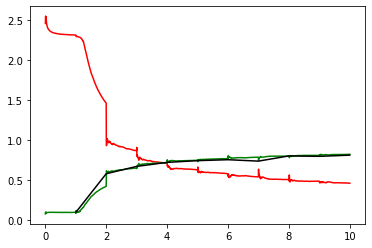

loss 0.466, train acc 0.827, test acc 0.816


In [26]:
train(net,train_iter,test_iter,num_epochs,lr,try_gpu())

In [28]:
!pwd

/content
